# 2. ResNet18

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

#Resizing the image size from 32x32x3 to 112x112x3
#conversion to tensor
#Normalizing
transform = transforms.Compose(
    [transforms.Resize((112, 112)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 500

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(trainset[2][0].shape)
print(len(trainset))

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 112, 112])
50000


In [14]:
#checking the device on which we're running
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


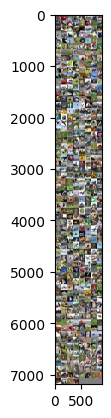

truck car   frog  horse cat   plane ship  truck cat   car   horse car   deer  car   bird  car   truck bird  cat   deer  cat   ship  frog  deer  bird  ship  cat   cat   car   deer  horse cat   dog   dog   bird  dog   truck plane horse frog  deer  bird  deer  deer  cat   car   cat   bird  frog  bird  frog  truck deer  car   deer  bird  plane bird  bird  plane ship  dog   frog  bird  plane truck frog  frog  dog   frog  car   horse cat   horse dog   truck horse horse deer  bird  truck truck plane cat   frog  deer  plane truck frog  car   truck bird  frog  truck horse frog  truck car   dog   ship  car   car   horse plane car   cat   ship  cat   truck horse deer  bird  deer  bird  bird  truck bird  dog   bird  frog  truck plane plane plane dog   car   truck ship  horse deer  bird  truck truck truck dog   car   bird  truck frog  deer  car   car   car   deer  plane plane frog  car   deer  bird  dog   dog   ship  bird  frog  dog   car   deer  dog   deer  deer  deer  frog  ship  plane plane hors

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [8]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class ResNet18(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18, self).__init__()

        self.relu = nn.ReLU()

        # BLOCK-1 (starting block) input=(112x112) output=(28x28)
        #input=(112x112) output=(56x56)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        #output=(28x28)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))

        # BLOCK-2 (1) input=(28x28) output = (28x28)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)

        # BLOCK-2 (2) input=(28x28) output = (28x28)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)


        # BLOCK-3 (1) input=(28x28) output = (14x14)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)

        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)


        # BLOCK-4 (1) input=(14x14) output = (7x7)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)

        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)


        # BLOCK-5 (1) input=(7x7) output = (4x4)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)

        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)


        # Final Block input=(4x4)
        self.avgpool = nn.AvgPool2d(kernel_size=(4,4), stride=(1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=1*1*512, out_features=1000)
        self.out = nn.Linear(in_features=1000, out_features=n_classes)
        # END

    def forward(self, x):

        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)


        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1

        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(x)))  # conv2_2
        x = self.batchnorm2_2_2(self.conv2_2_2(x))             # conv2_2
        op2 = self.relu(x)


        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1

        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(x)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2

        op3 = self.relu(x)


        # block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1

        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(x)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2

        op4 = self.relu(x)


        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1

        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(x)))  # conv5_2
        x = self.batchnorm5_2_1(self.conv5_2_1(x))                 # conv5_2

        op5 = self.relu(x)


        # FINAL BLOCK - classifier
        x = self.avgpool(op5)
        x = self.flatten(x)
        #fully connected layer
        x = self.relu(self.fc(x))
        x = self.out(x)

        return x


In [6]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import time

def applySoftmax(f_hat):
  return nn.functional.softmax(f_hat,dim =1)


#loss function
loss_metric = nn.CrossEntropyLoss()

num_episodes = 50

def parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
def NN_train_test(train_loader, test_loader, train_loss_mean_nn1, test_loss_mean_nn1, train_acc_mean_nn1, test_acc_mean_nn1, net, optimizer):
    for layer in net.children():
     if hasattr(layer,"reset_parameters"):
         layer.reset_parameters()
    if optimizer == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
        print("optimizer = SGD")
    else:
        optimizer = optim.Adam(net.parameters(), lr=0.01)
        print("optimizer = ADAM")

    train_loss_mean_nn1 = []
    test_loss_mean_nn1 = []
    train_acc_mean_nn1 = []  # List to store training accuracy
    test_acc_mean_nn1 = []   # List to store testing accuracy

    net = net.to(device)  # Move the model to GPU
    for episode in range(num_episodes):
        start = time.time()
        train_loss = []
        correct_train = 0  # Counter for correct predictions on training data
        total_train = 0    # Counter for total samples in training data

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            optimizer.zero_grad()
            Predict = net(inputs)
            loss = loss_metric(Predict, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            _, predicted_train = torch.max(Predict.data, 1)  # Get predicted labels
            correct_train += (predicted_train == targets).sum().item()  # Count correct predictions
            total_train += targets.size(0)  # Count total samples

        # Calculate training accuracy
        train_accuracy = correct_train / total_train

        with torch.no_grad():
            test_loss = []
            correct_test = 0   # Counter for correct predictions on testing data
            total_test = 0     # Counter for total samples in testing data

            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
                Predict = net(inputs)
                loss = loss_metric(Predict, targets)
                test_loss.append(loss.item())
                _, predicted_test = torch.max(Predict.data, 1)  # Get predicted labels
                correct_test += (predicted_test == targets).sum().item()  # Count correct predictions
                total_test += targets.size(0)  # Count total samples

        # Calculate testing accuracy
        test_accuracy = correct_test / total_test

        train_loss_mean_nn1.append(np.mean(train_loss))
        test_loss_mean_nn1.append(np.mean(test_loss))
        train_acc_mean_nn1.append(train_accuracy)
        test_acc_mean_nn1.append(test_accuracy)
        end = time.time()
        print(f"{episode} {end - start:.2f}", end=', ')

    return train_loss_mean_nn1, test_loss_mean_nn1, train_acc_mean_nn1, test_acc_mean_nn1





In [4]:
def plot_loss(train_loss, test_loss, train_acc, test_acc, num_params):
    """
    Function to plot loss and accuracy
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(8, 12))

    ax1.plot(train_loss)
    ax1.set_title(f"Training loss over episodes, Parameters {num_params}")
    ax1.set_ylabel("Loss")
    ax1.grid()

    ax2.plot(test_loss)
    ax2.set_title(f"Test loss over episodes, Parameters {num_params}")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Episodes")
    ax2.grid()

    ax3.plot(train_acc)
    ax3.set_title(f"Training accuracy over episodes, Parameters {num_params}")
    ax3.set_ylabel("Accuracy")
    ax3.grid()

    ax4.plot(test_acc)
    ax4.set_title(f"Test accuracy over episodes, Parameters {num_params}")
    ax4.set_ylabel("Accuracy")
    ax4.set_xlabel("Episodes")
    ax4.grid()

    plt.tight_layout()
    plt.show()

# Normal dataset, Optim = Adam

optimizer = ADAM
0 44.37, 1 44.08, 2 44.36, 3 43.82, 4 44.04, 5 43.98, 6 44.21, 7 44.35, 8 44.02, 9 44.19, 10 44.44, 11 44.32, 12 43.99, 13 44.87, 14 44.50, 15 44.14, 16 44.09, 17 44.19, 18 44.11, 19 44.44, 20 44.09, 21 43.80, 22 44.19, 23 44.13, 24 44.56, 25 44.17, 26 44.16, 27 44.43, 28 44.26, 29 44.43, 30 44.25, 31 44.21, 32 44.17, 33 43.95, 34 44.41, 35 44.04, 36 44.00, 37 43.94, 38 44.10, 39 44.25, 40 44.26, 41 44.02, 42 44.32, 43 44.07, 44 44.28, 45 44.24, 46 44.20, 47 43.90, 48 43.99, 49 44.32, train_loss: [2.253828922510147, 1.871262502670288, 1.66006250500679, 1.5436044883728028, 1.421330293416977, 1.312049845457077, 1.214127938747406, 1.1183046364784242, 1.039851991534233, 0.966646580696106, 0.9093081772327423, 0.8511817264556885, 0.8069455391168594, 0.7671153229475022, 0.724232605099678, 0.6769797945022583, 0.6371688419580459, 0.5919321772456169, 0.5473907715082169, 0.5066020882129669, 0.4802071487903595, 0.4570444643497467, 0.40907118350267413, 0.3879637935757637, 0.3493426

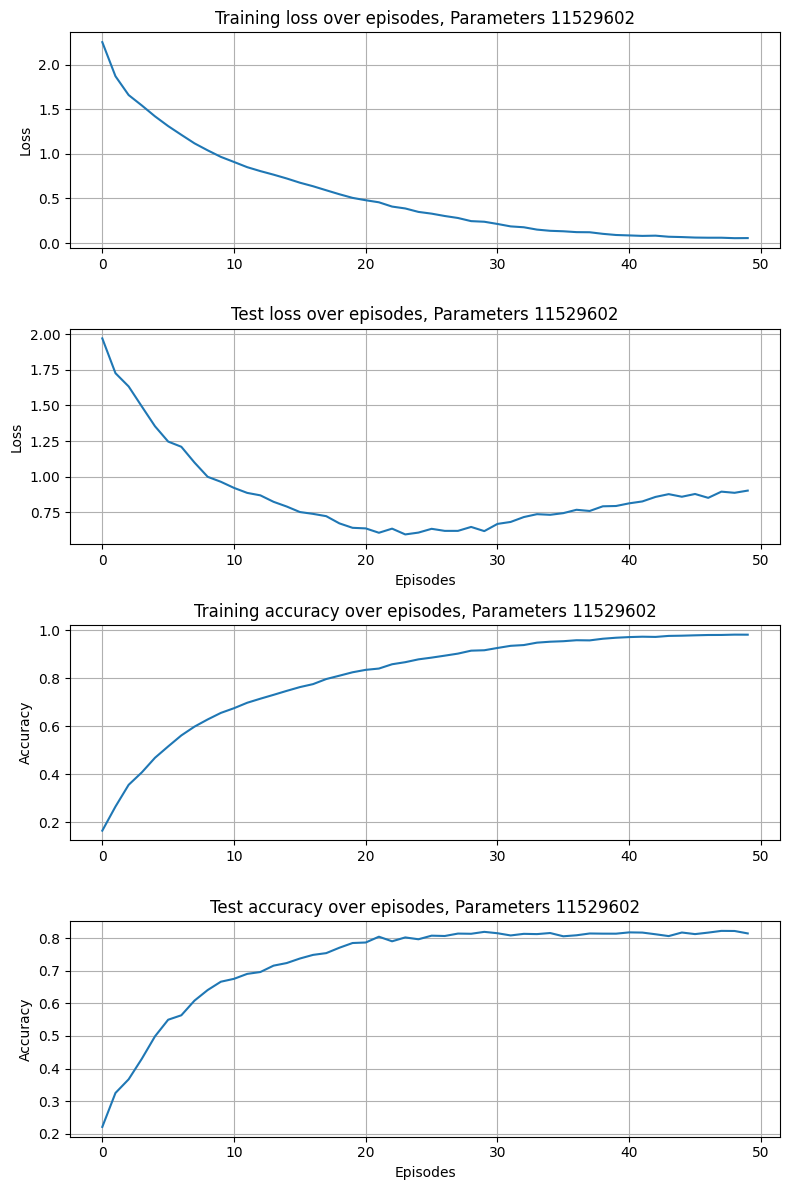

In [20]:
train_loss_mean_nn1 = []
test_loss_mean_nn1 = []
train_acc_mean_nn1 = []
test_acc_mean_nn1 = []
train_loss_mean_nn1, test_loss_mean_nn1, train_acc_mean_nn1, test_acc_mean_nn1 = NN_train_test(train_loader, test_loader, train_loss_mean_nn1, test_loss_mean_nn1, train_acc_mean_nn1, test_acc_mean_nn1, ResNet18(n_classes=10),"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn1,test_loss_mean_nn1,train_acc_mean_nn1, test_acc_mean_nn1))
plot_loss(train_loss_mean_nn1,test_loss_mean_nn1,train_acc_mean_nn1, test_acc_mean_nn1, parameters(ResNet18(n_classes=10)))

In [15]:
train_loss_mean_nn1 = [2.253828922510147, 1.871262502670288, 1.66006250500679, 1.5436044883728028, 1.421330293416977, 1.312049845457077, 1.214127938747406, 1.1183046364784242, 1.039851991534233, 0.966646580696106, 0.9093081772327423, 0.8511817264556885, 0.8069455391168594, 0.7671153229475022, 0.724232605099678, 0.6769797945022583, 0.6371688419580459, 0.5919321772456169, 0.5473907715082169, 0.5066020882129669, 0.4802071487903595, 0.4570444643497467, 0.40907118350267413, 0.3879637935757637, 0.3493426825106144, 0.3297335031628609, 0.3032475717365742, 0.28101565957069397, 0.24580656588077546, 0.23889497563242912, 0.21403426110744475, 0.18672705948352813, 0.17695120289921762, 0.1507086779177189, 0.13725682705640793, 0.13196496479213238, 0.1223443604260683, 0.12103572078049182, 0.10323564652353526, 0.09027697212994099, 0.08543760240077973, 0.08009599508717656, 0.08279370579868556, 0.07065771102905273, 0.06691891139373184, 0.061482695117592814, 0.059649638440459965, 0.05967786591500044, 0.05460449540987611, 0.0556011363863945]
test_loss_mean_nn1 = [1.9698139309883118, 1.725753664970398, 1.6327925205230713, 1.4923696994781495, 1.3536207139492036, 1.2462407290935515, 1.209790050983429, 1.0990867644548417, 0.9992244631052017, 0.9643211990594864, 0.9213939398527146, 0.8864137470722199, 0.8691786885261535, 0.8239130228757858, 0.7908100724220276, 0.7521827995777131, 0.7392666816711426, 0.7231810301542282, 0.6726499110460281, 0.6415196746587754, 0.6374192714691163, 0.6068316698074341, 0.6357323080301285, 0.5952059775590897, 0.6079890489578247, 0.6345253258943557, 0.6200395554304123, 0.6200906455516815, 0.6477360039949417, 0.6184337675571442, 0.6688987463712692, 0.6826705306768417, 0.7169540345668792, 0.7371396958827973, 0.7327009856700897, 0.7444221794605255, 0.7679559856653213, 0.7596400827169418, 0.7923885375261307, 0.7944619089365006, 0.8131752073764801, 0.8265596210956574, 0.8581822335720062, 0.8776393115520478, 0.8594558656215667, 0.8787148535251618, 0.8517134428024292, 0.8951270103454589, 0.8869997918605804, 0.9024544179439544]
train_acc_mean_nn1 = [0.16432, 0.26476, 0.35544, 0.40726, 0.4682, 0.51546, 0.56138, 0.5981, 0.62798, 0.65522, 0.67486, 0.69752, 0.71444, 0.73052, 0.74706, 0.76282, 0.7752, 0.79636, 0.81034, 0.8246, 0.83472, 0.8401, 0.85804, 0.86668, 0.87842, 0.8857, 0.89388, 0.90238, 0.91466, 0.91638, 0.9259, 0.93486, 0.93806, 0.94808, 0.952, 0.9541, 0.95816, 0.95752, 0.9644, 0.9686, 0.97128, 0.97288, 0.97198, 0.9762, 0.9771, 0.97866, 0.97998, 0.98018, 0.9815, 0.9813]
test_acc_mean_nn1 = [0.2204, 0.3248, 0.3668, 0.4299, 0.4989, 0.55, 0.5637, 0.6088, 0.6413, 0.6669, 0.6758, 0.691, 0.6967, 0.7163, 0.7243, 0.7382, 0.7494, 0.7548, 0.7714, 0.7859, 0.7875, 0.8053, 0.7912, 0.8031, 0.7974, 0.8085, 0.8075, 0.8149, 0.8143, 0.8202, 0.816, 0.8092, 0.8141, 0.8133, 0.8166, 0.8066, 0.8097, 0.8152, 0.8147, 0.8146, 0.8186, 0.818, 0.8128, 0.8072, 0.8182, 0.8133, 0.8179, 0.8232, 0.8229, 0.8154]

# Normal dataset, Optim = SGD

optimizer = SGD
0 44.24, 1 43.90, 2 43.90, 3 44.08, 4 44.17, 5 43.97, 6 44.18, 7 44.11, 8 44.01, 9 44.08, 10 44.52, 11 44.16, 12 44.19, 13 43.92, 14 44.05, 15 43.93, 16 44.15, 17 44.27, 18 43.82, 19 44.13, 20 43.98, 21 44.46, 22 44.28, 23 43.93, 24 44.01, 25 43.98, 26 44.21, 27 43.95, 28 44.02, 29 43.97, 30 44.28, 31 44.34, 32 43.98, 33 44.02, 34 44.21, 35 43.99, 36 44.30, 37 44.08, 38 43.95, 39 44.04, 40 44.14, 41 44.32, 42 43.83, 43 44.23, 44 44.03, 45 44.02, 46 44.23, 47 44.03, 48 43.78, 49 44.08, train_loss: [1.709715300798416, 1.0870060968399047, 0.8161790806055069, 0.6242243933677674, 0.4993161192536354, 0.39102484107017516, 0.29375276759266855, 0.22443126514554024, 0.20386754244565963, 0.13521975323557853, 0.1124696783721447, 0.07712535347789526, 0.05533518575131893, 0.04820826910436153, 0.046810663919895884, 0.045488942172378304, 0.037865923196077345, 0.03274456060491502, 0.03514027012512088, 0.029464859403669833, 0.029713673391379414, 0.026357751097530125, 0.018033767119050026

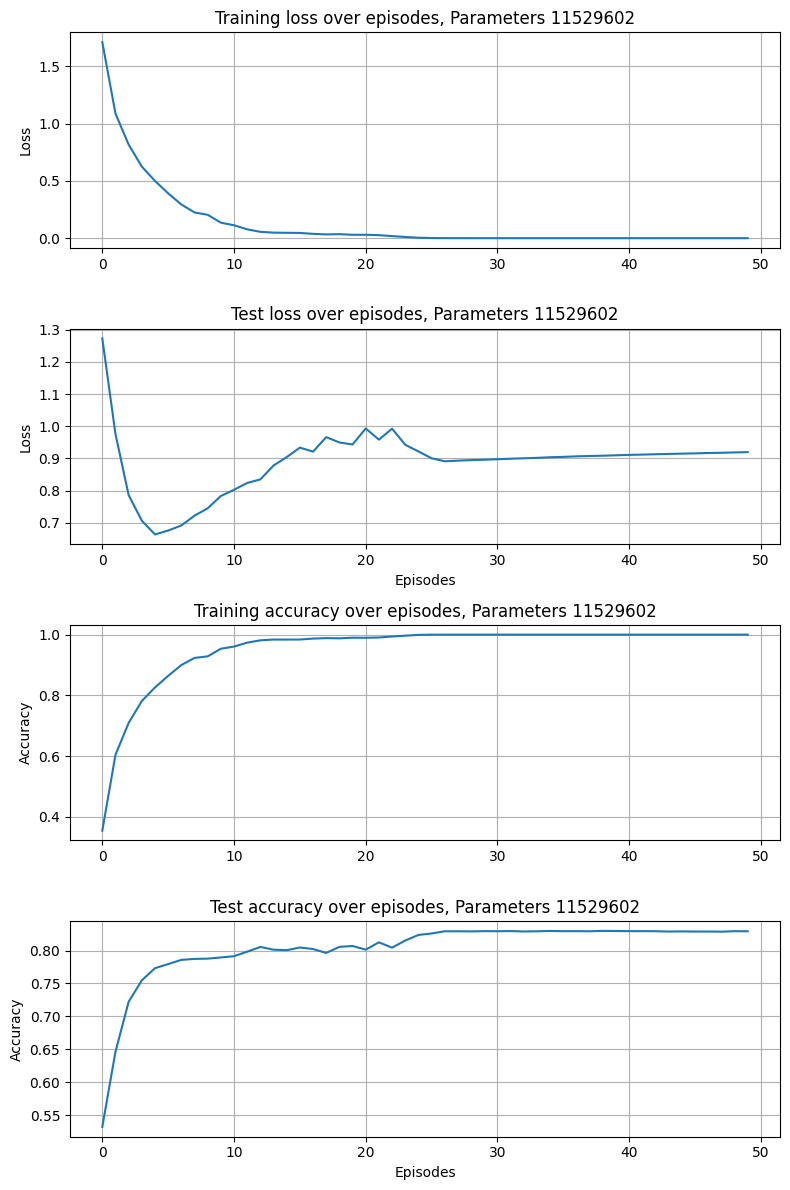

In [21]:
train_loss_mean_nn2 = []
test_loss_mean_nn2 = []
train_acc_mean_nn2 = []
test_acc_mean_nn2 = []
train_loss_mean_nn2, test_loss_mean_nn2, train_acc_mean_nn2, test_acc_mean_nn2 = NN_train_test(train_loader, test_loader, train_loss_mean_nn2, test_loss_mean_nn2, train_acc_mean_nn2, test_acc_mean_nn2, ResNet18(n_classes=10),"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_nn2,test_loss_mean_nn2,train_acc_mean_nn2, test_acc_mean_nn2))
plot_loss(train_loss_mean_nn2,test_loss_mean_nn2,train_acc_mean_nn2, test_acc_mean_nn2, parameters(ResNet18(n_classes=10)))

In [14]:
train_loss_mean_nn2 = [1.709715300798416, 1.0870060968399047, 0.8161790806055069, 0.6242243933677674, 0.4993161192536354, 0.39102484107017516, 0.29375276759266855, 0.22443126514554024, 0.20386754244565963, 0.13521975323557853, 0.1124696783721447, 0.07712535347789526, 0.05533518575131893, 0.04820826910436153, 0.046810663919895884, 0.045488942172378304, 0.037865923196077345, 0.03274456060491502, 0.03514027012512088, 0.029464859403669833, 0.029713673391379414, 0.026357751097530125, 0.018033767119050026, 0.01058153860969469, 0.0039991059852764015, 0.0010791683249408378, 0.0003013699731673114, 0.00018076547683449463, 0.00014735277130967006, 0.00013546163536375387, 0.00011801537068095058, 0.00010829295039002318, 0.00010361386972363107, 9.5260718735517e-05, 8.757327574130613e-05, 8.26382090235711e-05, 8.200948584999424e-05, 7.629398085555294e-05, 7.311348897928838e-05, 6.886412993480917e-05, 6.670522736385465e-05, 6.149886026832973e-05, 6.171090146381175e-05, 5.9903069486608727e-05, 6.025371611031005e-05, 5.404766408901196e-05, 5.472434811963467e-05, 5.337239470463828e-05, 5.242812421784038e-05, 4.8910307777987325e-05]
test_loss_mean_nn2 = [1.2731395959854126, 0.9755418568849563, 0.7858950048685074, 0.7063259422779083, 0.6635698705911637, 0.6756423652172089, 0.6913469314575196, 0.721826696395874, 0.744746744632721, 0.782976970076561, 0.8023581445217133, 0.8236128568649292, 0.8346809953451156, 0.8778109788894654, 0.9039898306131363, 0.9335351586341858, 0.9209076285362243, 0.9661331802606583, 0.9495431125164032, 0.9431813836097718, 0.9930584639310837, 0.9582679212093353, 0.9923857480287552, 0.9423497676849365, 0.9215535759925843, 0.90035480260849, 0.8909371584653855, 0.8930086493492126, 0.8946103274822235, 0.8957915365695953, 0.8974031984806061, 0.8989076972007751, 0.9003607720136643, 0.9016067445278168, 0.9035748302936554, 0.9046960085630417, 0.906328547000885, 0.907477080821991, 0.9083106338977813, 0.9096105188131333, 0.9109123826026917, 0.91177316904068, 0.9129056870937348, 0.9137879550457001, 0.9147984564304352, 0.9155995935201645, 0.91668601334095, 0.9174521327018738, 0.9185209155082703, 0.9194851845502854]
train_acc_mean_nn2 = [0.35484, 0.60454, 0.70948, 0.78154, 0.82622, 0.8642, 0.89988, 0.92332, 0.92848, 0.95356, 0.9608, 0.97364, 0.98128, 0.9838, 0.98374, 0.98394, 0.98696, 0.98852, 0.9879, 0.98986, 0.98958, 0.99062, 0.99384, 0.99656, 0.99914, 0.99988, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
test_acc_mean_nn2 = [0.5319, 0.6462, 0.7222, 0.7548, 0.7733, 0.7795, 0.7859, 0.7874, 0.7878, 0.7896, 0.7915, 0.7984, 0.8056, 0.8014, 0.8007, 0.8047, 0.8024, 0.7965, 0.8057, 0.807, 0.8015, 0.8126, 0.8045, 0.8154, 0.8238, 0.8261, 0.8294, 0.8294, 0.8292, 0.8296, 0.8295, 0.8297, 0.8291, 0.8294, 0.8299, 0.8295, 0.8296, 0.8294, 0.83, 0.8298, 0.8296, 0.8296, 0.8295, 0.829, 0.8292, 0.829, 0.829, 0.8288, 0.8295, 0.8294]

# **Permuted DataSet**

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
import numpy as np

torch.manual_seed(124532)
np.random.seed(124532)

#permutation function
def permute_pixels(x):
    # Permute each channel separately
    for i in range(x.size(0)):
        x[i] = x[i][torch.randperm(x[i].size(0))]
    return x

#Resizing the image size from 32x32x3 to 112x112x3
#conversion to tensor
#Normalizing
#then permutating the image pixels
transform_permuted = transforms.Compose(
    [transforms.Resize((112,112)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     Lambda(permute_pixels) # applying permutation
     ])

batch_size = 500

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_permuted)
train_loader_permuted = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_permuted)
test_loader_permuted = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(trainset[2][0].shape)
print(len(trainset))

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 112, 112])
50000


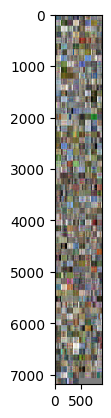

horse truck car   dog   truck truck ship  plane plane bird  plane dog   car   plane plane ship  bird  plane horse truck frog  cat   plane horse ship  horse truck horse frog  deer  deer  ship  truck horse truck dog   car   dog   frog  cat   frog  ship  frog  deer  frog  dog   truck bird  cat   frog  cat   cat   horse frog  cat   car   frog  plane cat   horse deer  bird  bird  ship  horse deer  truck frog  deer  car   ship  truck frog  frog  cat   truck cat   bird  frog  ship  bird  deer  deer  frog  frog  plane cat   plane bird  deer  dog   plane deer  deer  cat   bird  ship  cat   dog   ship  bird  cat   cat   frog  ship  frog  car   truck frog  plane frog  bird  ship  plane car   truck truck cat   frog  cat   bird  dog   dog   car   truck car   truck horse plane truck cat   plane car   ship  bird  horse cat   plane bird  car   car   bird  plane ship  cat   ship  dog   frog  deer  plane ship  deer  dog   ship  horse frog  truck plane plane ship  frog  deer  deer  bird  deer  deer  deer

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader_permuted)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [24]:
batch_size = 500

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_permuted)
train_loader_permuted = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_permuted)
test_loader_permuted = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(trainset[2][0].shape)
print(len(trainset))

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 112, 112])
50000


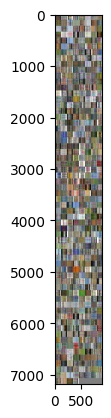

deer  plane cat   horse plane ship  plane deer  deer  deer  truck deer  frog  dog   dog   truck plane truck plane cat   dog   bird  bird  bird  bird  car   car   dog   deer  plane deer  frog  frog  cat   bird  deer  plane bird  frog  truck cat   plane cat   ship  car   cat   horse dog   frog  ship  plane horse cat   dog   dog   deer  plane deer  frog  horse horse ship  dog   truck car   deer  bird  deer  frog  plane bird  deer  dog   cat   deer  ship  bird  car   deer  truck plane truck horse horse ship  truck dog   dog   cat   truck truck car   bird  deer  car   horse horse car   cat   dog   dog   dog   cat   dog   dog   truck cat   bird  plane truck car   horse ship  truck car   deer  horse truck dog   car   plane bird  truck bird  plane plane dog   truck cat   bird  horse deer  frog  horse car   horse bird  ship  cat   frog  frog  bird  deer  dog   horse truck dog   plane cat   ship  dog   frog  truck bird  cat   horse ship  deer  car   truck frog  plane deer  plane ship  dog   bird

In [25]:

# get some random training images
dataiter = iter(train_loader_permuted)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Permuted dataset, Optim = Adam

optimizer = ADAM
0 45.55, 1 45.35, 2 45.56, 3 45.08, 4 45.46, 5 45.78, 6 45.51, 7 45.70, 8 45.54, 9 45.15, 10 45.29, 11 45.51, 12 45.59, 13 45.24, 14 45.76, 15 45.69, 16 45.69, 17 45.59, 18 45.30, 19 45.39, 20 45.43, 21 45.03, 22 45.36, 23 45.82, 24 45.46, 25 45.47, 26 45.64, 27 45.59, 28 45.61, 29 45.19, 30 45.45, 31 45.67, 32 45.76, 33 45.41, 34 45.53, 35 45.73, 36 45.50, 37 45.40, 38 45.33, 39 45.50, 40 45.76, 41 45.67, 42 45.63, 43 45.68, 44 45.75, 45 45.73, 46 45.68, 47 45.59, 48 45.72, 49 45.52, train_loss: [2.2948004269599913, 2.0148978567123415, 1.972352465391159, 1.937143452167511, 1.8992738711833954, 1.8681033396720885, 1.8304431557655334, 1.807827124595642, 1.7811943423748016, 1.7687334728240967, 1.7470031774044037, 1.7382767367362977, 1.7240749430656432, 1.703479641675949, 1.6804717314243316, 1.652783638238907, 1.626931049823761, 1.6075326561927796, 1.57983358502388, 1.5608515417575837, 1.5330079519748687, 1.5121729040145875, 1.4915498292446137, 1.4636120069026948, 1.439342

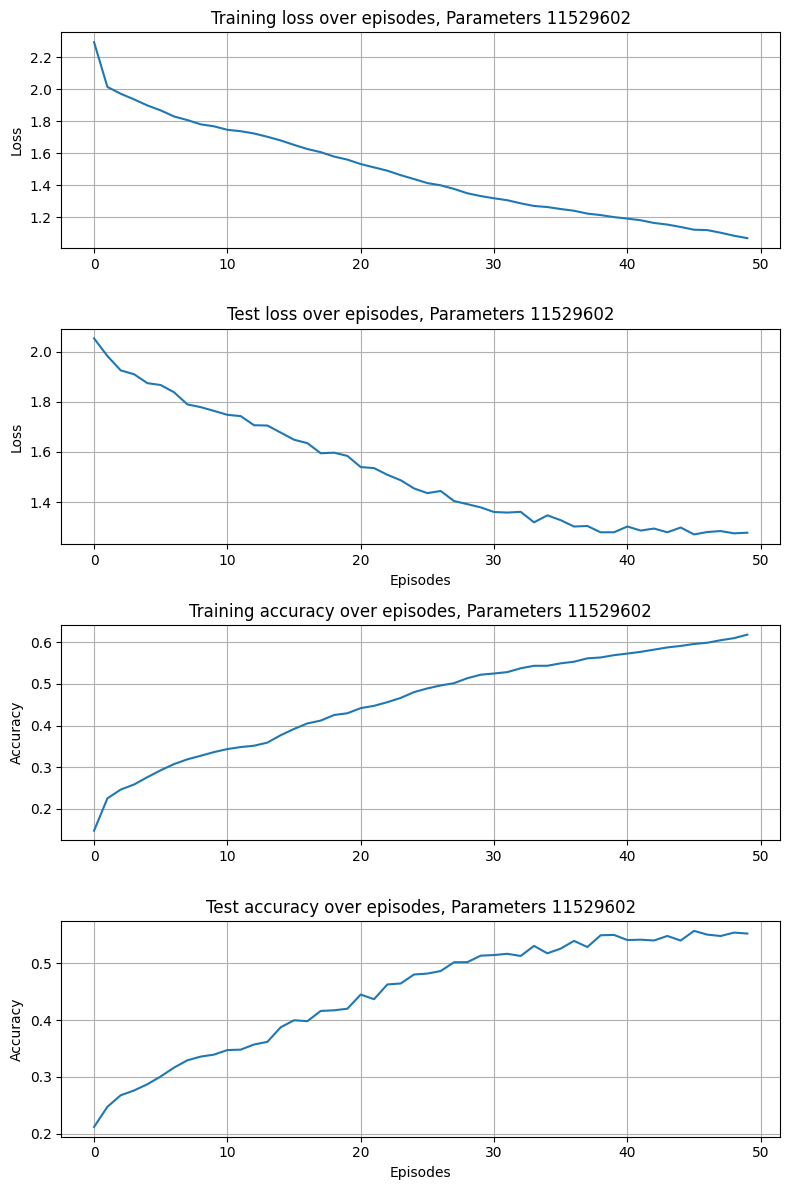

In [26]:
train_loss_mean_perm_nn1 = []
test_loss_mean_perm_nn1 = []
train_acc_mean_perm_nn1 = []
test_acc_mean_perm_nn1 = []
train_loss_mean_perm_nn1, test_loss_mean_perm_nn1, train_acc_mean_perm_nn1, test_acc_mean_perm_nn1 = NN_train_test(train_loader_permuted, test_loader_permuted, train_loss_mean_perm_nn1, test_loss_mean_perm_nn1, train_acc_mean_perm_nn1, test_acc_mean_perm_nn1, ResNet18(n_classes=10),"ADAM")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn1,test_loss_mean_perm_nn1,train_acc_mean_perm_nn1, test_acc_mean_perm_nn1))
plot_loss(train_loss_mean_perm_nn1,test_loss_mean_perm_nn1,train_acc_mean_perm_nn1, test_acc_mean_perm_nn1, parameters(ResNet18(n_classes=10)))

In [12]:
train_loss_mean_perm_nn1 = [2.2948004269599913, 2.0148978567123415, 1.972352465391159, 1.937143452167511, 1.8992738711833954, 1.8681033396720885, 1.8304431557655334, 1.807827124595642, 1.7811943423748016, 1.7687334728240967, 1.7470031774044037, 1.7382767367362977, 1.7240749430656432, 1.703479641675949, 1.6804717314243316, 1.652783638238907, 1.626931049823761, 1.6075326561927796, 1.57983358502388, 1.5608515417575837, 1.5330079519748687, 1.5121729040145875, 1.4915498292446137, 1.4636120069026948, 1.4393427634239198, 1.414231208562851, 1.4002060627937316, 1.377659831047058, 1.3505099821090698, 1.3330086004734039, 1.319183338880539, 1.3069381058216094, 1.2877211952209473, 1.2711254715919496, 1.2644738411903382, 1.252067791223526, 1.241385487318039, 1.2234420800209045, 1.214191462993622, 1.2015829956531525, 1.192223905324936, 1.1819917809963227, 1.1650085687637328, 1.1549866247177123, 1.1399056661128997, 1.1228636288642884, 1.1203482401371003, 1.1039341324567795, 1.085214483141899, 1.0699791187047958]
test_loss_mean_perm_nn1 = [2.0531748294830323, 1.9828603208065032, 1.925437366962433, 1.9100819766521453, 1.8745498597621917, 1.8670450031757355, 1.838131582736969, 1.789746743440628, 1.7788572013378143, 1.7638339042663573, 1.7482103824615478, 1.7430025339126587, 1.70664284825325, 1.7054519951343536, 1.677250337600708, 1.64880051612854, 1.6352306365966798, 1.5948749899864196, 1.5971272587776184, 1.5842687964439393, 1.5397559344768523, 1.5356091558933258, 1.5089462280273438, 1.4871001839637756, 1.4545003533363343, 1.435780370235443, 1.4442718982696534, 1.4041497468948365, 1.3917436599731445, 1.3788821876049042, 1.3604295134544373, 1.358139193058014, 1.3611807763576507, 1.3191791474819183, 1.3471247792243957, 1.3279031753540038, 1.302523809671402, 1.3046054422855378, 1.2794574975967408, 1.2796332478523254, 1.3025399327278138, 1.2864099800586701, 1.2943790435791016, 1.2795080065727233, 1.298582923412323, 1.2709929764270782, 1.2805892705917359, 1.2843768894672394, 1.2753751516342162, 1.2777480959892273]
train_acc_mean_perm_nn1 = [0.1471, 0.22472, 0.24594, 0.25814, 0.27578, 0.2924, 0.30724, 0.31868, 0.3272, 0.3361, 0.34334, 0.34816, 0.3514, 0.3589, 0.37668, 0.39174, 0.40504, 0.41178, 0.42526, 0.42944, 0.44182, 0.4473, 0.4561, 0.46632, 0.48028, 0.48916, 0.49634, 0.50178, 0.51374, 0.52218, 0.52504, 0.52844, 0.53764, 0.54356, 0.54364, 0.54954, 0.55336, 0.5615, 0.56364, 0.56914, 0.573, 0.57712, 0.58246, 0.58776, 0.59134, 0.59608, 0.59902, 0.60514, 0.61004, 0.61852]
test_acc_mean_perm_nn1 = [0.2121, 0.2475, 0.2678, 0.2762, 0.2872, 0.3009, 0.3164, 0.3293, 0.3358, 0.3393, 0.3473, 0.348, 0.3571, 0.3617, 0.3874, 0.3997, 0.3981, 0.4161, 0.4172, 0.42, 0.4449, 0.4367, 0.4627, 0.4644, 0.4802, 0.4818, 0.4863, 0.5017, 0.5019, 0.5133, 0.5144, 0.5166, 0.5128, 0.5305, 0.5174, 0.5257, 0.5393, 0.5285, 0.5492, 0.5498, 0.5408, 0.5414, 0.54, 0.548, 0.5399, 0.5569, 0.5503, 0.5479, 0.5539, 0.5522]

# Permuted dataset, Optim = SGD

In [ ]:
train_loss_mean_perm_nn2 = []
test_loss_mean_perm_nn2 = []
train_acc_mean_perm_nn2 = []
test_acc_mean_perm_nn2 = []
train_loss_mean_perm_nn2, test_loss_mean_perm_nn2, train_acc_mean_perm_nn2, test_acc_mean_perm_nn2 = NN_train_test(train_loader_permuted, test_loader_permuted, train_loss_mean_perm_nn2, test_loss_mean_perm_nn2, train_acc_mean_perm_nn2, test_acc_mean_perm_nn2, ResNet18(n_classes=10),"SGD")
print('train_loss: {}\n test_loss: {}\n train_acc: {}\n test_acc: {}'.format(train_loss_mean_perm_nn2,test_loss_mean_perm_nn2,train_acc_mean_perm_nn2, test_acc_mean_perm_nn2))
plot_loss(train_loss_mean_perm_nn2,test_loss_mean_perm_nn2,train_acc_mean_perm_nn2, test_acc_mean_perm_nn2, parameters(ResNet18(n_classes=10)))

optimizer = SGD
0 45.49, 1 45.69, 2 45.64, 3 45.13, 4 45.66, 5 45.54, 6 45.54, 7 45.55, 8 45.74, 9 45.47, 10 45.59, 11 45.33, 12 45.48, 13 45.48, 14 45.65, 15 45.79, 16 45.50, 17 45.89, 18 45.66, 19 46.02, 20 45.62, 21 46.02, 22 45.87, 23 46.38, 24 46.53, 25 46.10, 26 46.24, 27 46.66, 28 46.23, 29 45.52, 30 46.17, 31 45.41, 32 45.95, 33 45.67, 34 45.43, 35 45.74, 36 45.67, 37 45.88, 38 45.54, 39 46.05, 40 45.58, 41 45.97, 42 45.76, 43 45.60, 44 45.88, 45 45.67, 46 45.81, 47 45.68, 48 46.11, 49 45.78, train_loss: [1.9762494623661042, 1.7347070121765136, 1.5855484998226166, 1.4793456244468688, 1.4030052614212036, 1.3281810140609742, 1.279222581386566, 1.2212843465805054, 1.163717533349991, 1.109092057943344, 1.0504572409391404, 0.9913736343383789, 0.9494348126649856, 0.8850934809446335, 0.8295434951782227, 0.7619026720523834, 0.7121785753965377, 0.6495541688799858, 0.5997810217738152, 0.547173445224762, 0.4920049437880516, 0.44782169073820116, 0.3986978456377983, 0.36040552288293837, 0.3

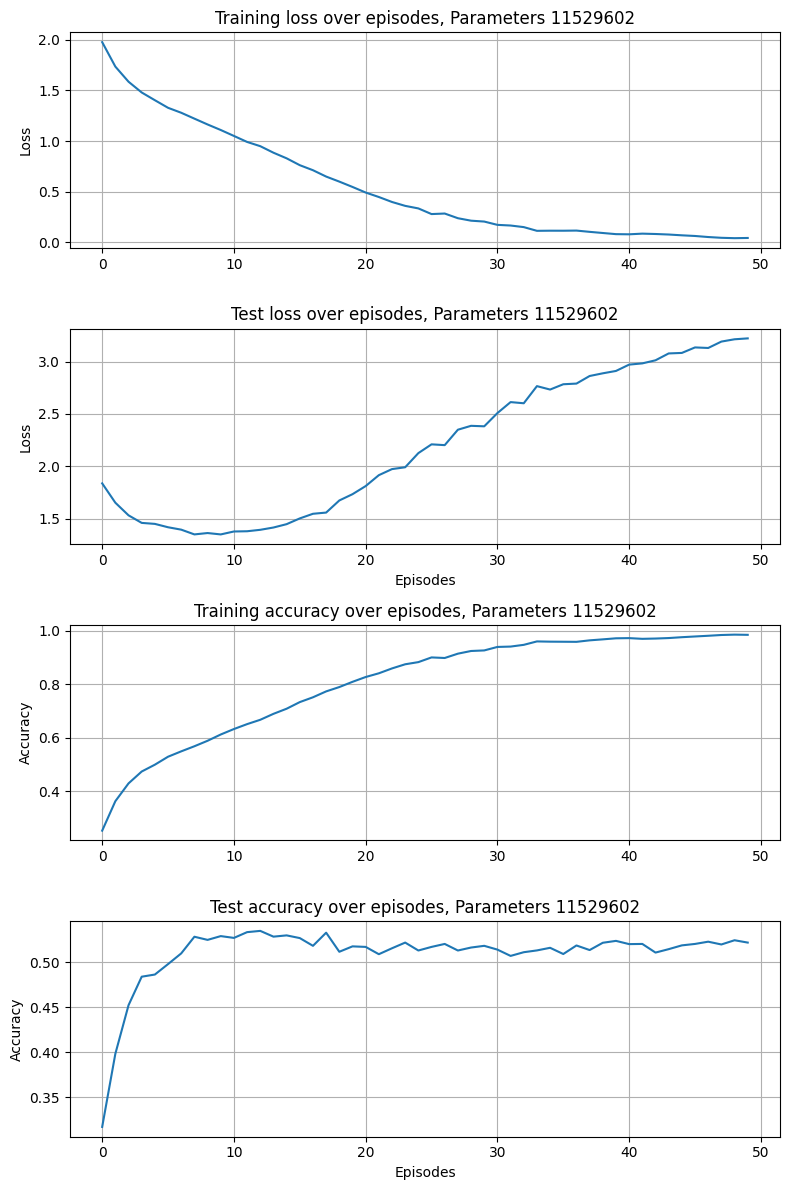

In [11]:
import matplotlib.pyplot as plt

train_loss_mean_perm_nn2 = [1.9762494623661042, 1.7347070121765136, 1.5855484998226166, 1.4793456244468688, 1.4030052614212036, 1.3281810140609742, 1.279222581386566, 1.2212843465805054, 1.163717533349991, 1.109092057943344, 1.0504572409391404, 0.9913736343383789, 0.9494348126649856, 0.8850934809446335, 0.8295434951782227, 0.7619026720523834, 0.7121785753965377, 0.6495541688799858, 0.5997810217738152, 0.547173445224762, 0.4920049437880516, 0.44782169073820116, 0.3986978456377983, 0.36040552288293837, 0.33521342277526855, 0.27948289856314656, 0.2847286461293697, 0.238584473580122, 0.21422181025147438, 0.20554271951317787, 0.172972130253911, 0.16647039033472538, 0.1507605741173029, 0.11413905940949917, 0.11540231738239527, 0.11513494491577149, 0.1165522563830018, 0.10407510802149772, 0.09263664625585079, 0.08139109823852778, 0.07977692101150752, 0.08630361579358578, 0.08279605247080327, 0.07762961942702531, 0.06980469383299351, 0.06324769731611013, 0.05287753846496344, 0.045256452523171904, 0.041642067665234206, 0.04363749302923679]
test_loss_mean_perm_nn2 = [1.8361810803413392, 1.6509556233882905, 1.5303376734256744, 1.4579664945602417, 1.4484477460384368, 1.4162233710289, 1.3933119297027587, 1.3478195369243622, 1.360871821641922, 1.3477058231830596, 1.3757368445396423, 1.3780177056789398, 1.3918212532997132, 1.413721787929535, 1.4458785891532897, 1.5008304417133331, 1.545124703645706, 1.556677383184433, 1.672556984424591, 1.7325757682323455, 1.8102429389953614, 1.9145826339721679, 1.972652119398117, 1.9901836097240448, 2.1255903780460357, 2.209427314996719, 2.201858776807785, 2.349375069141388, 2.38665167093277, 2.381945562362671, 2.508444917201996, 2.613597500324249, 2.6024496793746947, 2.7663723826408386, 2.733555483818054, 2.78429251909256, 2.7906983375549315, 2.8632856249809264, 2.888989043235779, 2.9116095185279844, 2.972209644317627, 2.9839492321014403, 3.0135103106498717, 3.079108381271362, 3.0840319752693177, 3.136662745475769, 3.1313817381858824, 3.19251070022583, 3.214551901817322, 3.2231233596801756]
train_acc_mean_perm_nn2 = [0.25144, 0.36184, 0.42852, 0.473, 0.49858, 0.52844, 0.54854, 0.56762, 0.58816, 0.61168, 0.63212, 0.65052, 0.66678, 0.68904, 0.7082, 0.73302, 0.75104, 0.7731, 0.78936, 0.80894, 0.82696, 0.8409, 0.85914, 0.87468, 0.88276, 0.90036, 0.8982, 0.9144, 0.92444, 0.92654, 0.9396, 0.94098, 0.94748, 0.9603, 0.95938, 0.95906, 0.95872, 0.9643, 0.968, 0.97196, 0.97264, 0.96998, 0.97106, 0.9729, 0.9761, 0.97882, 0.98144, 0.98432, 0.9857, 0.98496]
test_acc_mean_perm_nn2 = [0.3168, 0.3981, 0.452, 0.4837, 0.4861, 0.4977, 0.5096, 0.5281, 0.5246, 0.5288, 0.5268, 0.5332, 0.5346, 0.5282, 0.5296, 0.5266, 0.518, 0.5326, 0.5114, 0.5174, 0.5168, 0.5087, 0.5153, 0.5216, 0.5128, 0.5168, 0.5201, 0.5128, 0.5161, 0.518, 0.5138, 0.5068, 0.5109, 0.5129, 0.5158, 0.5089, 0.5184, 0.5133, 0.5214, 0.5235, 0.5199, 0.5201, 0.5105, 0.5143, 0.5185, 0.5201, 0.5226, 0.5195, 0.5242, 0.5216]
plot_loss(train_loss_mean_perm_nn2,test_loss_mean_perm_nn2,train_acc_mean_perm_nn2, test_acc_mean_perm_nn2, parameters(ResNet18(n_classes=10)))

In [36]:
def parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
import matplotlib.pyplot as plt
def get_label(i,num_parameters):
  if i == 0:
    return f"Normal dataset with Adam optim - Parameters {num_parameters[i]}"
  if i == 1:
    return "Normal dataset with SGD optim"
  if i == 2:
    return "Permuted dataset with Adam optim"
  if i == 3:
    return "Permuted dataset with SGD optim"

def plot_acc_NNs(train_losses, test_losses, num_params):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
    for i in range(len(train_losses)):
        ax1.plot(train_losses[i], label=get_label(i, num_params))
        ax2.plot(test_losses[i], label=get_label(i, num_params))

    ax1.set_title("Training Accuracy over episodes")
    ax1.set_ylabel("Accuracy")
    ax1.grid()

    ax2.set_title("Test Accuracy over episodes")
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Episodes")
    ax2.grid()

    ax1.legend()
    ax2.legend()

In [18]:
def plot_loss_NNs(train_losses, test_losses, num_params):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
    for i in range(len(train_losses)):
        ax1.plot(train_losses[i], label=get_label(i, num_params))
        ax2.plot(test_losses[i], label=get_label(i, num_params))

    ax1.set_title("Training loss over episodes")
    ax1.set_ylabel("Loss")
    ax1.grid()

    ax2.set_title("Test loss over episodes")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Episodes")
    ax2.grid()

    ax1.legend()
    ax2.legend()

# Combining all graphs

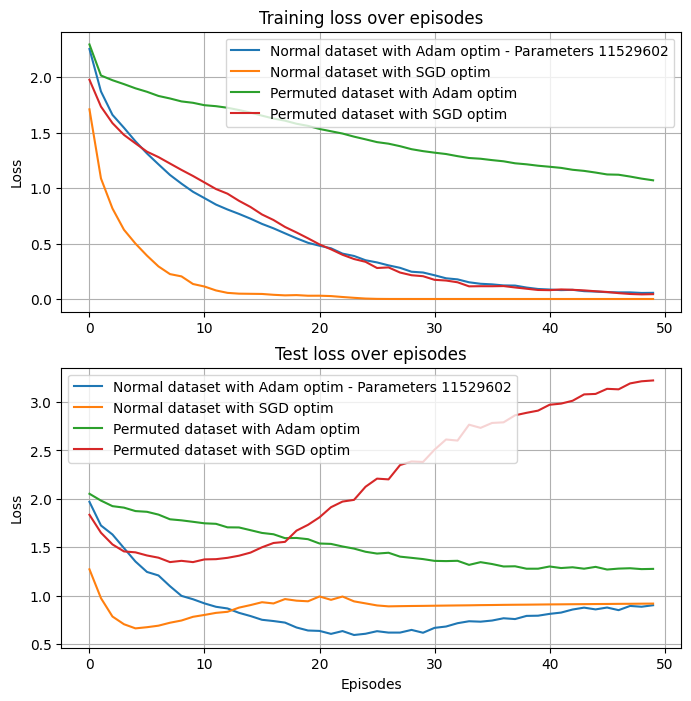

In [19]:
plot_loss_NNs([train_loss_mean_nn1, train_loss_mean_nn2, train_loss_mean_perm_nn1, train_loss_mean_perm_nn2],
          [test_loss_mean_nn1, test_loss_mean_nn2, test_loss_mean_perm_nn1, test_loss_mean_perm_nn2],
          [parameters(ResNet18(n_classes=10)), parameters(ResNet18(n_classes=10)),parameters(ResNet18(n_classes=10)),parameters(ResNet18(n_classes=10))])

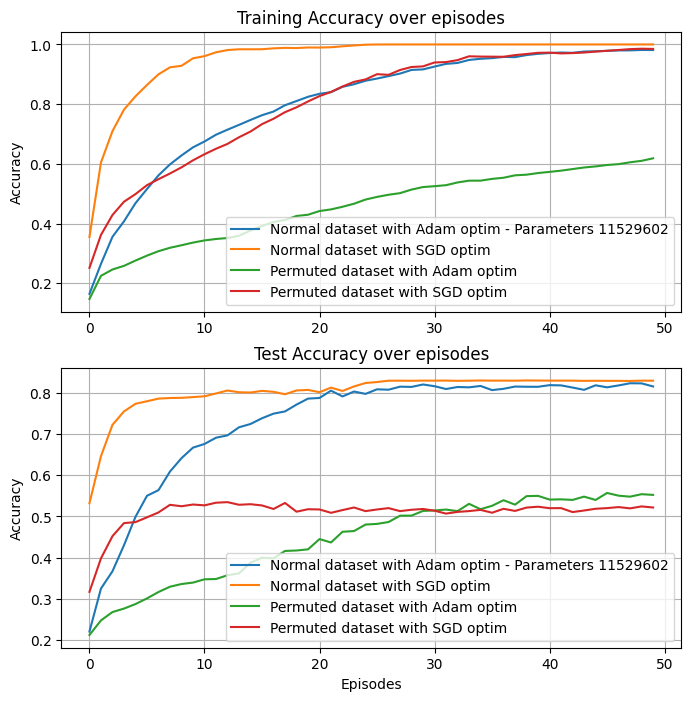

In [40]:
plot_acc_NNs([train_acc_mean_nn1, train_acc_mean_nn2, train_acc_mean_perm_nn1, train_acc_mean_perm_nn2],
          [test_acc_mean_nn1, test_acc_mean_nn2, test_acc_mean_perm_nn1, test_acc_mean_perm_nn2],
          [parameters(ResNet18(n_classes=10)), parameters(ResNet18(n_classes=10)),parameters(ResNet18(n_classes=10)),parameters(ResNet18(n_classes=10))])
